In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import division
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms as transforms
import pandas as pd
import os
import pydicom
import numpy as np
import glob
from os import listdir
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from skimage.color import gray2rgb
import functools
import seaborn as sns
import scipy
import PIL
import json
import torch
from torch.utils.data import Dataset
import pandas as pd
import random
import numpy as np
import time
import os, json
from torch import nn
import monai, cv2
from tqdm import tqdm as tqdm

In [11]:
def process_from_npy(img):
    '''
    Convert from uint8 saved 3D npy array to float32
    '''
    CONTRAST_HU_MEAN = 0.15897
    img = img.astype(np.float32) / 255
    img = img - CONTRAST_HU_MEAN

    # crop
    row = (img.shape[-2] - 192) // 2
    col = (img.shape[-1] - 192) // 2
    img = img[:,row : row + 192, col : col + 192]

    return img

target_cols = [
            'negative_exam_for_pe', # exam level
            'rv_lv_ratio_gte_1', # exam level
            'rv_lv_ratio_lt_1', # exam level
            'leftsided_pe', # exam level
            'chronic_pe', # exam level
            'rightsided_pe', # exam level
            'acute_and_chronic_pe', # exam level
            'central_pe', # exam level
            'indeterminate' # exam level
        ]
device = 'cuda'

In [12]:
epochs = 100
learning_rate = 0.001
gamma = 0.5
momentum = 0.6
decay = 0.0005
schedule = [20, 40, 60, 80]
schedule = []
ngpu = 1
prefetch = 2
BCE_weight = 6.42

class KagglePEDataset(Dataset):
    """Kaggle PE dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            root_dir (string): Directory with preprocessed npy images.
            transform (callable, optional): Not handled
        """
        self.pedataframe = pd.read_csv(csv_file)
        self.studies = self.pedataframe.StudyInstanceUID.unique()
        self.root_dir = root_dir
        self.transform = transform
        self.preprocess_tabular_data()

    def __len__(self):
        """ Return number of studies"""
        #return len(self.pedataframe)
        #return len(self.studies)
        return 1024 # Start with a small sample

    def preprocess_tabular_data(self):
        '''
        preprocess the pandas dataframe so it doesn't take too much time when loading data.
        '''
        self.df_cache = []
        df_i = 0

        for study_index in range(len(self)):
            studyId = self.studies[study_index]
            start_i = df_i
            assert self.pedataframe['StudyInstanceUID'][start_i] == self.studies[study_index]
            while self.pedataframe['StudyInstanceUID'][df_i] == self.studies[study_index]:
                df_i += 1

            # append (start_index, end_index) of study into data frame.
            self.df_cache.append((start_i, df_i))
            
    def __getitem__(self, idx):
        a = time.perf_counter()
        
        # filter dataframe by study (this is already ordered by z-position)
        studyId = self.studies[idx]

        study_file = self.root_dir + studyId + '.npy' # load preprocessed 3D np array of the CT scan
        img = np.load(study_file) # Nx208x208 int 8
        img = process_from_npy(img) # Nx192x192 (center cropped) float 32

        pe_present_on_image = False # TODO
        
        transform = monai.transforms.Resize((192,192,192))
        img = transform(np.expand_dims(img, axis=0))
        
        target_list = []
        
        for label in target_cols:
            target_item = self.pedataframe[label][self.df_cache[idx][0]]
            target_list.append(target_item)
            
        target = torch.tensor(target_list)
        
        return img, target.float()

In [13]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection-208-npy/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'
dataset = KagglePEDataset(csv_file=train_csv, root_dir=train_dir)

In [14]:
len(dataset)

1024

In [15]:
img, target = dataset[97]
print(img.shape)
print(target)

(1, 192, 192, 192)
tensor([0., 1., 0., 0., 0., 1., 0., 0., 0.])


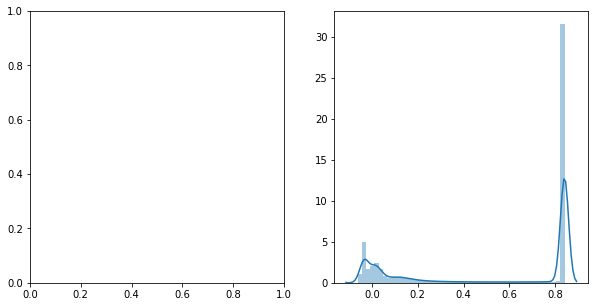

In [16]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.distplot(img.flatten(), ax=ax[1]);

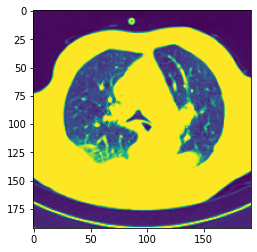

In [18]:
plt.imshow(img.squeeze(0)[120,:,:])

In [19]:
bce = nn.BCEWithLogitsLoss()
def criterion(logits, target):
    loss = bce(logits.view(-1), target.view(-1))
    return loss

In [20]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)       
        loss = criterion(logits, target)

        loss.backward()
 
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(model, loader, is_ext=None, n_test=1, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)
            LOGITS.append(logits.detach().cpu())
            TARGETS.append(target.detach().cpu())

    val_loss = criterion(torch.cat(LOGITS), torch.cat(TARGETS)).numpy()
    PROBS = torch.sigmoid(torch.cat(LOGITS)).numpy().squeeze()    
    LOGITS = torch.cat(LOGITS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()
    
    if get_output:
        return LOGITS, PROBS, TARGETS
    else:
        acc = (PROBS.round() == TARGETS).mean() * 100.
        auc = roc_auc_score(TARGETS, LOGITS)
        return float(val_loss), acc, auc

In [13]:
def run():
    #df_train = df_study[(df_study['fold'] != fold)]
    #df_valid = df_study[(df_study['fold'] == fold)]
    data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection-208-npy/'
    train_csv = data_dir + 'train.csv'
    train_dir = data_dir + 'train/'
    
    dataset_train = KagglePEDataset(csv_file=train_csv, root_dir=train_dir)
    #dataset_train = RSNADataset3D(df_train, 'train', transform=train_transforms)
    #dataset_valid = RSNADataset3D(df_valid, 'val', transform=val_transforms)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=2, num_workers=1)
    #valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=8, num_workers=num_workers)

    model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=len(target_cols))
    model = model.to(device)

    #val_loss_best = 1000
    #model_file = f'{kernel_type}_best_fold{fold}.pth'

    init_lr = 0.05
    n_epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

    print(len(dataset_train))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        #scheduler_warmup.step(epoch-1)

        train_loss = train_epoch(model, train_loader, optimizer)
        #val_loss, acc, auc = val_epoch(model, valid_loader)
        val_loss = 0
        acc = 0
        auc = 0
    
        content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(val_loss):.5f}, acc: {(acc):.4f}, auc: {(auc):.6f}'
        print(content)
        
        #with open(f'log_{kernel_type}.txt', 'a') as appender:
        #    appender.write(content + '\n')             
            
        #if val_loss < val_loss_best:
        #    print('val_loss_best ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_best, val_loss))
        #    torch.save(model.state_dict(), model_file)
        #    val_loss_best = val_loss

    #torch.save(model.state_dict(), f'{kernel_type}_model_fold{fold}.pth')

In [14]:
run()

  0%|          | 0/64 [00:00<?, ?it/s]

128
Sun Nov 15 19:02:09 2020 Epoch: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:03:35 2020 Epoch 1, lr: 0.0500000, train loss: 0.64695, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:03:35 2020 Epoch: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:05:02 2020 Epoch 2, lr: 0.0500000, train loss: 0.35017, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:05:02 2020 Epoch: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:06:28 2020 Epoch 3, lr: 0.0500000, train loss: 0.33680, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:06:28 2020 Epoch: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:07:55 2020 Epoch 4, lr: 0.0500000, train loss: 0.32502, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:07:55 2020 Epoch: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:09:22 2020 Epoch 5, lr: 0.0500000, train loss: 0.32552, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:09:22 2020 Epoch: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:10:48 2020 Epoch 6, lr: 0.0500000, train loss: 0.31524, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:10:48 2020 Epoch: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:12:15 2020 Epoch 7, lr: 0.0500000, train loss: 0.32004, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:12:15 2020 Epoch: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:13:42 2020 Epoch 8, lr: 0.0500000, train loss: 0.31695, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:13:42 2020 Epoch: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:15:08 2020 Epoch 9, lr: 0.0500000, train loss: 0.31160, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:15:08 2020 Epoch: 10


loss: 1.09882, smth: 0.30687: 100%|██████████| 64/64 [01:27<00:00,  1.36s/it]

Sun Nov 15 19:16:35 2020 Epoch 10, lr: 0.0500000, train loss: 0.30687, valid loss: 0.00000, acc: 0.0000, auc: 0.000000


In [15]:
def run():
    data_dir = '/scratch/rsna-str-pulmonary-embolism-detection-208-npy/'
    train_csv = data_dir + 'train.csv'
    train_dir = data_dir + 'train/'
    
    dataset_train = KagglePEDataset(csv_file=train_csv, root_dir=train_dir)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=2, num_workers=1)

    model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=len(target_cols))
    model = model.to(device)

    init_lr = 0.01
    n_epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

    print(len(dataset_train))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        #scheduler_warmup.step(epoch-1)

        train_loss = train_epoch(model, train_loader, optimizer)
        #val_loss, acc, auc = val_epoch(model, valid_loader)
        val_loss = 0
        acc = 0
        auc = 0
    
        content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(val_loss):.5f}, acc: {(acc):.4f}, auc: {(auc):.6f}'
        print(content)

    torch.save(model.state_dict(), 'model.pth')

In [16]:
run()

  0%|          | 0/64 [00:00<?, ?it/s]

128
Sun Nov 15 19:27:43 2020 Epoch: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:29:10 2020 Epoch 1, lr: 0.0100000, train loss: 0.39142, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:29:10 2020 Epoch: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:30:37 2020 Epoch 2, lr: 0.0100000, train loss: 0.37270, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:30:37 2020 Epoch: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:32:04 2020 Epoch 3, lr: 0.0100000, train loss: 0.34830, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:32:04 2020 Epoch: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:33:31 2020 Epoch 4, lr: 0.0100000, train loss: 0.34437, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:33:31 2020 Epoch: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:34:59 2020 Epoch 5, lr: 0.0100000, train loss: 0.32546, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:34:59 2020 Epoch: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:36:26 2020 Epoch 6, lr: 0.0100000, train loss: 0.32701, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:36:26 2020 Epoch: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:37:53 2020 Epoch 7, lr: 0.0100000, train loss: 0.32435, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:37:53 2020 Epoch: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:39:20 2020 Epoch 8, lr: 0.0100000, train loss: 0.31910, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:39:20 2020 Epoch: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:40:47 2020 Epoch 9, lr: 0.0100000, train loss: 0.31708, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:40:47 2020 Epoch: 10


loss: 1.14777, smth: 0.31826: 100%|██████████| 64/64 [01:27<00:00,  1.37s/it]


Sun Nov 15 19:42:14 2020 Epoch 10, lr: 0.0100000, train loss: 0.31826, valid loss: 0.00000, acc: 0.0000, auc: 0.000000


In [19]:
def run():
    data_dir = '/scratch/rsna-str-pulmonary-embolism-detection-208-npy/'
    train_csv = data_dir + 'train.csv'
    train_dir = data_dir + 'train/'
    
    dataset_train = KagglePEDataset(csv_file=train_csv, root_dir=train_dir)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=2, num_workers=1)

    model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=len(target_cols))
    model.load_state_dict(torch.load('model.pth', map_location=device))
    model = model.to(device)

    init_lr = 0.005
    n_epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

    print(len(dataset_train))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        #scheduler_warmup.step(epoch-1)

        train_loss = train_epoch(model, train_loader, optimizer)
        #val_loss, acc, auc = val_epoch(model, valid_loader)
        val_loss = 0
        acc = 0
        auc = 0
    
        content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(val_loss):.5f}, acc: {(acc):.4f}, auc: {(auc):.6f}'
        print(content)

        torch.save(model.state_dict(), 'model.pth')

In [20]:
run()

  0%|          | 0/64 [00:00<?, ?it/s]

128
Sun Nov 15 19:45:52 2020 Epoch: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:47:19 2020 Epoch 1, lr: 0.0050000, train loss: 0.31359, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:47:19 2020 Epoch: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:48:47 2020 Epoch 2, lr: 0.0050000, train loss: 0.30779, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:48:47 2020 Epoch: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:50:14 2020 Epoch 3, lr: 0.0050000, train loss: 0.31210, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:50:14 2020 Epoch: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:51:42 2020 Epoch 4, lr: 0.0050000, train loss: 0.31181, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:51:42 2020 Epoch: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:53:09 2020 Epoch 5, lr: 0.0050000, train loss: 0.30773, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:53:10 2020 Epoch: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:54:37 2020 Epoch 6, lr: 0.0050000, train loss: 0.30933, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:54:37 2020 Epoch: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:56:05 2020 Epoch 7, lr: 0.0050000, train loss: 0.30918, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:56:05 2020 Epoch: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:57:32 2020 Epoch 8, lr: 0.0050000, train loss: 0.30470, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:57:32 2020 Epoch: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Sun Nov 15 19:59:00 2020 Epoch 9, lr: 0.0050000, train loss: 0.30345, valid loss: 0.00000, acc: 0.0000, auc: 0.000000
Sun Nov 15 19:59:00 2020 Epoch: 10


loss: 1.10596, smth: 0.30257: 100%|██████████| 64/64 [01:27<00:00,  1.36s/it]


Sun Nov 15 20:00:27 2020 Epoch 10, lr: 0.0050000, train loss: 0.30257, valid loss: 0.00000, acc: 0.0000, auc: 0.000000


In [22]:
def test(model, loader):

    model.eval()

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)
            probs = torch.sigmoid(logits)  
            print('target: ', target, ' probs: ', probs)

def run():
    data_dir = '/scratch/rsna-str-pulmonary-embolism-detection-208-npy/'
    train_csv = data_dir + 'train.csv'
    train_dir = data_dir + 'train/'
    
    dataset_train = KagglePEDataset(csv_file=train_csv, root_dir=train_dir)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=1, num_workers=1)

    model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=len(target_cols))
    model.load_state_dict(torch.load('model.pth', map_location=device))
    model = model.to(device)
    
    test(model, train_loader)

In [23]:
run()

  1%|          | 1/128 [00:00<00:47,  2.68it/s]

target:  tensor([[0., 0., 1., 1., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[8.8977e-01, 3.3601e-02, 7.4642e-02, 6.2599e-02, 2.6995e-04, 1.0574e-01,
         1.7120e-02, 3.0840e-03, 3.8534e-04]], device='cuda:0')
target:  

  2%|▏         | 3/128 [00:00<00:31,  3.91it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7568, 0.1052, 0.1094, 0.1228, 0.0363, 0.1794, 0.0056, 0.0582, 0.0045]],
       device='cuda:0')
target:  tensor([[0., 0., 1., 0., 1., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.8486, 0.0579, 0.0940, 0.0874, 0.0018, 0.1358, 0.0184, 0.0094, 0.0014]],
       device='cuda:0')
target:  

  4%|▍         | 5/128 [00:00<00:24,  5.09it/s]

tensor([[0., 0., 1., 1., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.1900e-01, 1.7245e-02, 4.5571e-02, 4.0844e-02, 4.8942e-05, 7.3185e-02,
         5.6563e-03, 1.1054e-03, 7.8944e-05]], device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9920e-01, 1.0535e-05, 7.2306e-04, 3.2256e-04, 3.9981e-15, 1.3540e-03,
         1.3845e-04, 1.2344e-09, 5.2317e-12]], device='cuda:0')
target:  

  5%|▌         | 7/128 [00:01<00:20,  5.95it/s]

tensor([[0., 0., 1., 1., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7620, 0.1206, 0.1380, 0.1421, 0.0225, 0.1960, 0.0224, 0.0394, 0.0072]],
       device='cuda:0')
target:  tensor([[0., 1., 0., 1., 0., 1., 1., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7065, 0.1692, 0.1637, 0.1782, 0.0629, 0.2334, 0.0247, 0.0764, 0.0160]],
       device='cuda:0')
target:  

  7%|▋         | 9/128 [00:01<00:18,  6.46it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7622, 0.1001, 0.1052, 0.1183, 0.0335, 0.1743, 0.0049, 0.0551, 0.0040]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7331, 0.1285, 0.1271, 0.1423, 0.0496, 0.2009, 0.0089, 0.0705, 0.0076]],
       device='cuda:0')
target:  

  9%|▊         | 11/128 [00:01<00:17,  6.69it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.8746e-01, 8.2372e-04, 8.3982e-03, 5.8040e-03, 3.0059e-09, 1.4524e-02,
         1.2749e-03, 3.7989e-06, 8.9703e-08]], device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.3742e-01, 1.2664e-02, 3.9949e-02, 3.2391e-02, 1.7540e-05, 6.2064e-02,
         6.6778e-03, 6.0417e-04, 4.4135e-05]], device='cuda:0')
target:  

 10%|█         | 13/128 [00:02<00:16,  6.95it/s]

tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7054, 0.1585, 0.1484, 0.1664, 0.0702, 0.2242, 0.0144, 0.0840, 0.0127]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.7053e-01, 3.7429e-03, 2.0498e-02, 1.4843e-02, 3.2604e-07, 3.2517e-02,
         3.8927e-03, 5.7058e-05, 2.8745e-06]], device='cuda:0')
target:  

 12%|█▏        | 15/128 [00:02<00:15,  7.12it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9606e-01, 1.3561e-04, 3.0799e-03, 1.6819e-03, 1.2458e-11, 5.4643e-03,
         4.8150e-04, 1.5468e-07, 1.4852e-09]], device='cuda:0')
target:  tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7732, 0.0906, 0.0972, 0.1094, 0.0287, 0.1643, 0.0038, 0.0494, 0.0030]],
       device='cuda:0')
target:  

 13%|█▎        | 17/128 [00:02<00:15,  7.01it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.7907e-01, 2.1347e-03, 1.4840e-02, 1.0405e-02, 5.6988e-08, 2.4032e-02,
         2.8426e-03, 2.0222e-05, 8.3876e-07]], device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7082, 0.1599, 0.1506, 0.1679, 0.0683, 0.2259, 0.0157, 0.0866, 0.0137]],
       device='cuda:0')
target:  

 15%|█▍        | 19/128 [00:02<00:16,  6.71it/s]

tensor([[0., 1., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9729e-01, 6.9079e-05, 2.1509e-03, 1.1872e-03, 1.2905e-12, 3.8527e-03,
         4.1489e-04, 3.6837e-08, 3.6051e-10]], device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7099, 0.1665, 0.1631, 0.1761, 0.0593, 0.2314, 0.0254, 0.0726, 0.0154]],
       device='cuda:0')


 16%|█▌        | 20/128 [00:03<00:16,  6.73it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9714e-01, 1.0216e-04, 2.4689e-03, 1.2932e-03, 5.9090e-12, 4.1872e-03,
         5.6287e-04, 7.1486e-08, 1.0239e-09]], device='cuda:0')
target:  

 16%|█▋        | 21/128 [00:03<00:16,  6.46it/s]

tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9859e-01, 2.6434e-05, 1.1609e-03, 5.9718e-04, 8.4182e-14, 2.1603e-03,
         2.1583e-04, 6.7215e-09, 5.0075e-11]], device='cuda:0')
target:  

 18%|█▊        | 23/128 [00:03<00:17,  5.94it/s]

tensor([[0., 1., 0., 1., 0., 1., 0., 1., 0.]], device='cuda:0')  probs:  tensor([[9.0265e-01, 2.5603e-02, 5.8585e-02, 5.1575e-02, 1.3844e-04, 8.8593e-02,
         1.0293e-02, 1.8611e-03, 1.9621e-04]], device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.7521e-01, 2.8515e-03, 1.8238e-02, 1.2402e-02, 1.3154e-07, 2.8526e-02,
         3.7754e-03, 3.4483e-05, 1.6155e-06]], device='cuda:0')
target:  

 20%|█▉        | 25/128 [00:03<00:16,  6.38it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7068, 0.1640, 0.1600, 0.1736, 0.0612, 0.2293, 0.0222, 0.0708, 0.0138]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7288, 0.1347, 0.1323, 0.1479, 0.0532, 0.2052, 0.0100, 0.0720, 0.0084]],
       device='cuda:0')
target:  

 21%|██        | 27/128 [00:04<00:14,  6.74it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7384, 0.1232, 0.1232, 0.1378, 0.0466, 0.1956, 0.0079, 0.0670, 0.0066]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7143, 0.1482, 0.1413, 0.1585, 0.0628, 0.2161, 0.0123, 0.0785, 0.0106]],
       device='cuda:0')
target:  

 23%|██▎       | 29/128 [00:04<00:14,  7.01it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.8963e-01, 7.6408e-04, 7.8684e-03, 5.1130e-03, 3.0033e-09, 1.2922e-02,
         1.8519e-03, 2.7420e-06, 1.0859e-07]], device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.8277, 0.0636, 0.0921, 0.0918, 0.0038, 0.1424, 0.0100, 0.0151, 0.0016]],
       device='cuda:0')
target:  

 24%|██▍       | 31/128 [00:04<00:14,  6.85it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7643, 0.1176, 0.1326, 0.1386, 0.0208, 0.1944, 0.0190, 0.0421, 0.0070]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.6286e-01, 5.0158e-03, 2.4788e-02, 1.8961e-02, 5.8421e-07, 3.9612e-02,
         4.2022e-03, 9.5543e-05, 4.8119e-06]], device='cuda:0')


 25%|██▌       | 32/128 [00:04<00:14,  6.82it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.3704e-01, 1.1453e-02, 3.6479e-02, 3.1504e-02, 1.1610e-05, 5.9604e-02,
         4.8007e-03, 4.9865e-04, 3.3406e-05]], device='cuda:0')
target:  

 27%|██▋       | 34/128 [00:05<00:14,  6.67it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9775e-01, 5.6144e-05, 1.7442e-03, 9.7721e-04, 9.0078e-13, 3.2538e-03,
         2.8852e-04, 2.6480e-08, 2.6323e-10]], device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9836e-01, 3.8366e-05, 1.4241e-03, 7.5808e-04, 1.6130e-13, 2.5949e-03,
         2.9322e-04, 1.1331e-08, 9.9270e-11]], device='cuda:0')
target:  

 28%|██▊       | 36/128 [00:05<00:13,  6.88it/s]

tensor([[0., 0., 1., 1., 0., 1., 1., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7317, 0.1304, 0.1289, 0.1442, 0.0506, 0.2028, 0.0094, 0.0724, 0.0080]],
       device='cuda:0')
target:  tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7150, 0.1492, 0.1422, 0.1588, 0.0629, 0.2178, 0.0126, 0.0809, 0.0111]],
       device='cuda:0')
target:  

 30%|██▉       | 38/128 [00:05<00:12,  7.00it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.1995e-01, 1.9925e-02, 5.0426e-02, 4.3961e-02, 6.1244e-05, 7.5836e-02,
         1.0314e-02, 1.0900e-03, 1.2096e-04]], device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7176, 0.1535, 0.1502, 0.1650, 0.0559, 0.2224, 0.0175, 0.0766, 0.0127]],
       device='cuda:0')


 30%|███       | 39/128 [00:06<00:16,  5.41it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7592, 0.1173, 0.1330, 0.1390, 0.0217, 0.1937, 0.0182, 0.0398, 0.0064]],
       device='cuda:0')


 31%|███▏      | 40/128 [00:06<00:17,  5.14it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.8429, 0.0613, 0.0955, 0.0897, 0.0027, 0.1388, 0.0163, 0.0115, 0.0016]],
       device='cuda:0')
target:  

 33%|███▎      | 42/128 [00:06<00:14,  6.00it/s]

tensor([[0., 1., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7016, 0.1663, 0.1566, 0.1742, 0.0732, 0.2313, 0.0176, 0.0876, 0.0149]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.2003e-01, 2.0067e-02, 4.9049e-02, 4.2689e-02, 7.0785e-05, 7.6443e-02,
         8.0971e-03, 1.3687e-03, 1.2765e-04]], device='cuda:0')
target:  

 34%|███▍      | 44/128 [00:06<00:12,  6.54it/s]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')  probs:  tensor([[0.8350, 0.0607, 0.0917, 0.0907, 0.0028, 0.1389, 0.0115, 0.0123, 0.0014]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[8.7159e-01, 3.7684e-02, 6.9867e-02, 6.6358e-02, 6.1568e-04, 1.1033e-01,
         7.9553e-03, 5.4895e-03, 4.7967e-04]], device='cuda:0')
target:  

 36%|███▌      | 46/128 [00:07<00:12,  6.78it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7409, 0.1263, 0.1301, 0.1431, 0.0404, 0.1999, 0.0113, 0.0612, 0.0076]],
       device='cuda:0')
target:  tensor([[0., 0., 1., 0., 0., 1., 0., 1., 0.]], device='cuda:0')  probs:  tensor([[9.1112e-01, 2.0578e-02, 5.3336e-02, 4.5055e-02, 7.7665e-05, 8.2825e-02,
         7.1139e-03, 1.6149e-03, 1.1457e-04]], device='cuda:0')


 37%|███▋      | 47/128 [00:07<00:12,  6.34it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7729, 0.0909, 0.0974, 0.1097, 0.0288, 0.1646, 0.0039, 0.0495, 0.0030]],
       device='cuda:0')
target:  

 38%|███▊      | 49/128 [00:07<00:12,  6.30it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7080, 0.1557, 0.1467, 0.1639, 0.0676, 0.2229, 0.0138, 0.0837, 0.0122]],
       device='cuda:0')
target:  tensor([[0., 1., 0., 1., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7567, 0.1054, 0.1097, 0.1231, 0.0363, 0.1797, 0.0056, 0.0585, 0.0046]],
       device='cuda:0')


 39%|███▉      | 50/128 [00:07<00:12,  6.24it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7064, 0.1655, 0.1558, 0.1726, 0.0692, 0.2284, 0.0186, 0.0812, 0.0144]],
       device='cuda:0')
target:  

 41%|████      | 52/128 [00:08<00:11,  6.58it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7541, 0.1077, 0.1113, 0.1251, 0.0376, 0.1819, 0.0059, 0.0596, 0.0048]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.6677e-01, 4.7883e-03, 2.3420e-02, 1.7324e-02, 7.3690e-07, 3.6346e-02,
         5.0038e-03, 8.3947e-05, 5.4788e-06]], device='cuda:0')
target:  

 42%|████▏     | 54/128 [00:08<00:10,  6.79it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[8.7770e-01, 3.9413e-02, 7.4112e-02, 6.7580e-02, 5.9320e-04, 1.1097e-01,
         1.2548e-02, 4.8335e-03, 5.8075e-04]], device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9918e-01, 1.2939e-05, 7.8983e-04, 3.5383e-04, 8.1126e-15, 1.4143e-03,
         1.9191e-04, 1.5456e-09, 9.6330e-12]], device='cuda:0')
target:  

 44%|████▍     | 56/128 [00:08<00:10,  6.92it/s]

tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.6841, 0.1819, 0.1659, 0.1857, 0.0884, 0.2399, 0.0201, 0.0872, 0.0167]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7408, 0.1229, 0.1237, 0.1387, 0.0447, 0.1955, 0.0085, 0.0657, 0.0068]],
       device='cuda:0')


 45%|████▍     | 57/128 [00:08<00:10,  6.72it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7734, 0.0905, 0.0971, 0.1093, 0.0286, 0.1641, 0.0038, 0.0493, 0.0030]],
       device='cuda:0')
target:  

 46%|████▌     | 59/128 [00:09<00:10,  6.76it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.8513, 0.0511, 0.0822, 0.0795, 0.0019, 0.1262, 0.0094, 0.0099, 0.0010]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.1609e-01, 2.0527e-02, 5.1027e-02, 4.5360e-02, 7.0774e-05, 7.9396e-02,
         8.1325e-03, 1.3963e-03, 1.3681e-04]], device='cuda:0')
target:  

 48%|████▊     | 61/128 [00:09<00:09,  6.90it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[8.6436e-01, 4.0131e-02, 7.7537e-02, 7.1440e-02, 5.7841e-04, 1.1716e-01,
         1.0011e-02, 5.0367e-03, 4.7124e-04]], device='cuda:0')
target:  tensor([[0., 1., 0., 1., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7318, 0.1434, 0.1474, 0.1586, 0.0431, 0.2156, 0.0193, 0.0648, 0.0111]],
       device='cuda:0')
target:  

 48%|████▊     | 62/128 [00:09<00:09,  6.93it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7283, 0.1459, 0.1549, 0.1619, 0.0351, 0.2177, 0.0257, 0.0506, 0.0102]],
       device='cuda:0')
target:  

 50%|█████     | 64/128 [00:09<00:10,  6.23it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7393, 0.1231, 0.1231, 0.1378, 0.0460, 0.1960, 0.0081, 0.0680, 0.0069]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7977, 0.0911, 0.1186, 0.1177, 0.0087, 0.1718, 0.0189, 0.0243, 0.0038]],
       device='cuda:0')
target:  

 52%|█████▏    | 66/128 [00:10<00:09,  6.62it/s]

tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.8022, 0.0849, 0.1107, 0.1113, 0.0087, 0.1642, 0.0143, 0.0235, 0.0031]],
       device='cuda:0')
target:  tensor([[0., 1., 0., 1., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.2766e-01, 1.5894e-02, 4.6872e-02, 3.9212e-02, 2.7615e-05, 7.1108e-02,
         8.8014e-03, 8.3694e-04, 7.3351e-05]], device='cuda:0')
target:  

 53%|█████▎    | 68/128 [00:10<00:08,  6.87it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9248e-01, 3.8034e-04, 5.9197e-03, 3.5868e-03, 2.2206e-10, 9.8267e-03,
         1.1912e-03, 7.9011e-07, 1.5549e-08]], device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7589, 0.1150, 0.1296, 0.1361, 0.0240, 0.1935, 0.0148, 0.0459, 0.0063]],
       device='cuda:0')
target:  

 55%|█████▍    | 70/128 [00:10<00:08,  7.05it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7736, 0.0903, 0.0969, 0.1091, 0.0285, 0.1640, 0.0038, 0.0492, 0.0030]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7697, 0.1136, 0.1313, 0.1355, 0.0190, 0.1905, 0.0192, 0.0381, 0.0063]],
       device='cuda:0')
target:  

 56%|█████▋    | 72/128 [00:11<00:08,  6.99it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.6798, 0.1897, 0.1709, 0.1911, 0.0916, 0.2458, 0.0229, 0.0918, 0.0192]],
       device='cuda:0')
target:  tensor([[0., 1., 0., 1., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.8848e-01, 8.7659e-04, 8.6156e-03, 5.4090e-03, 4.1268e-09, 1.4244e-02,
         1.5882e-03, 4.1254e-06, 1.0685e-07]], device='cuda:0')
target:  

 58%|█████▊    | 74/128 [00:11<00:07,  7.01it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.8128, 0.0747, 0.1019, 0.1031, 0.0061, 0.1548, 0.0113, 0.0204, 0.0023]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.7815e-01, 2.3312e-03, 1.5118e-02, 1.0574e-02, 9.3932e-08, 2.4466e-02,
         2.7003e-03, 2.5639e-05, 9.9097e-07]], device='cuda:0')
target:  

 59%|█████▉    | 76/128 [00:11<00:07,  7.04it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7619, 0.1004, 0.1053, 0.1185, 0.0337, 0.1746, 0.0050, 0.0553, 0.0040]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9431e-01, 2.4116e-04, 4.0691e-03, 2.5883e-03, 6.9771e-11, 7.2699e-03,
         6.7229e-04, 3.6256e-07, 6.6314e-09]], device='cuda:0')
target:  

 61%|██████    | 78/128 [00:11<00:07,  7.02it/s]

tensor([[0., 1., 0., 1., 1., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7959, 0.0855, 0.1078, 0.1117, 0.0104, 0.1657, 0.0107, 0.0285, 0.0032]],
       device='cuda:0')
target:  tensor([[0., 0., 1., 1., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7456, 0.1212, 0.1269, 0.1390, 0.0389, 0.1955, 0.0104, 0.0593, 0.0068]],
       device='cuda:0')


 62%|██████▏   | 79/128 [00:12<00:07,  6.84it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.6874, 0.1838, 0.1702, 0.1878, 0.0823, 0.2409, 0.0249, 0.0798, 0.0173]],
       device='cuda:0')
target:  

 63%|██████▎   | 81/128 [00:12<00:06,  6.94it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7721, 0.0916, 0.0980, 0.1103, 0.0291, 0.1654, 0.0039, 0.0500, 0.0031]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7938, 0.0941, 0.1189, 0.1203, 0.0096, 0.1740, 0.0188, 0.0261, 0.0042]],
       device='cuda:0')
target:  

 65%|██████▍   | 83/128 [00:12<00:06,  6.97it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7570, 0.1176, 0.1348, 0.1408, 0.0202, 0.1977, 0.0180, 0.0424, 0.0065]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.0574e-01, 2.5363e-02, 5.7256e-02, 5.0212e-02, 1.7800e-04, 8.7523e-02,
         8.8155e-03, 2.2994e-03, 2.1596e-04]], device='cuda:0')
target:  

 66%|██████▋   | 85/128 [00:12<00:06,  6.99it/s]

tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7409, 0.1343, 0.1510, 0.1548, 0.0278, 0.2123, 0.0255, 0.0467, 0.0090]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7462, 0.1264, 0.1356, 0.1445, 0.0314, 0.2018, 0.0158, 0.0530, 0.0079]],
       device='cuda:0')
target:  

 68%|██████▊   | 87/128 [00:13<00:05,  6.86it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7899, 0.0955, 0.1226, 0.1216, 0.0103, 0.1765, 0.0196, 0.0258, 0.0041]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7732, 0.0907, 0.0972, 0.1095, 0.0287, 0.1644, 0.0038, 0.0495, 0.0030]],
       device='cuda:0')


 69%|██████▉   | 88/128 [00:13<00:05,  6.90it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7673, 0.0958, 0.1015, 0.1143, 0.0313, 0.1697, 0.0044, 0.0525, 0.0035]],
       device='cuda:0')
target:  

 70%|███████   | 90/128 [00:13<00:05,  6.94it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.8182, 0.0763, 0.1064, 0.1038, 0.0050, 0.1541, 0.0179, 0.0157, 0.0024]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9776e-01, 5.4240e-05, 1.7626e-03, 9.4265e-04, 6.1157e-13, 3.2971e-03,
         2.5922e-04, 2.6796e-08, 1.9776e-10]], device='cuda:0')
target:  

 72%|███████▏  | 92/128 [00:13<00:05,  6.98it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7548, 0.1075, 0.1109, 0.1245, 0.0373, 0.1815, 0.0058, 0.0591, 0.0048]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7374, 0.1243, 0.1239, 0.1390, 0.0470, 0.1973, 0.0083, 0.0687, 0.0070]],
       device='cuda:0')
target:  

 73%|███████▎  | 94/128 [00:14<00:04,  6.94it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7419, 0.1198, 0.1205, 0.1351, 0.0442, 0.1931, 0.0076, 0.0661, 0.0064]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9649e-01, 1.2592e-04, 2.9386e-03, 1.5620e-03, 9.2883e-12, 5.0113e-03,
         6.0537e-04, 1.0684e-07, 1.4701e-09]], device='cuda:0')
target:  

 75%|███████▌  | 96/128 [00:14<00:04,  6.68it/s]

tensor([[0., 0., 1., 1., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7734, 0.0904, 0.0971, 0.1093, 0.0286, 0.1641, 0.0038, 0.0493, 0.0030]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7115, 0.1580, 0.1527, 0.1683, 0.0605, 0.2243, 0.0182, 0.0738, 0.0127]],
       device='cuda:0')


 76%|███████▌  | 97/128 [00:14<00:04,  6.34it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.2232e-01, 1.7199e-02, 4.5187e-02, 3.9744e-02, 5.0463e-05, 7.2248e-02,
         5.8242e-03, 1.1472e-03, 8.4354e-05]], device='cuda:0')
target:  

 77%|███████▋  | 99/128 [00:14<00:04,  6.68it/s]

tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7062, 0.1653, 0.1588, 0.1746, 0.0672, 0.2313, 0.0202, 0.0831, 0.0154]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7136, 0.1547, 0.1502, 0.1657, 0.0617, 0.2229, 0.0165, 0.0782, 0.0127]],
       device='cuda:0')


 78%|███████▊  | 100/128 [00:15<00:04,  6.41it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[8.9936e-01, 2.8142e-02, 6.1555e-02, 5.3732e-02, 2.1733e-04, 9.2426e-02,
         1.0420e-02, 2.4596e-03, 2.6222e-04]], device='cuda:0')
target:  

 80%|███████▉  | 102/128 [00:15<00:04,  6.44it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.2416e-01, 1.7708e-02, 4.6161e-02, 3.9412e-02, 5.7190e-05, 7.1803e-02,
         6.6780e-03, 1.1962e-03, 9.3055e-05]], device='cuda:0')
target:  tensor([[0., 1., 0., 1., 0., 1., 0., 1., 0.]], device='cuda:0')  probs:  tensor([[0.6890, 0.1787, 0.1641, 0.1835, 0.0848, 0.2376, 0.0198, 0.0863, 0.0164]],
       device='cuda:0')


 80%|████████  | 103/128 [00:15<00:03,  6.28it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.6974, 0.1683, 0.1559, 0.1744, 0.0769, 0.2321, 0.0167, 0.0884, 0.0148]],
       device='cuda:0')
target:  

 82%|████████▏ | 105/128 [00:15<00:03,  6.49it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.9289e-01, 4.5827e-04, 5.6350e-03, 3.6461e-03, 6.3446e-10, 9.3161e-03,
         1.4757e-03, 9.6931e-07, 3.5964e-08]], device='cuda:0')
target:  tensor([[0., 0., 1., 1., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7729, 0.0909, 0.0974, 0.1097, 0.0288, 0.1646, 0.0039, 0.0496, 0.0030]],
       device='cuda:0')


 83%|████████▎ | 106/128 [00:16<00:03,  6.34it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7370, 0.1305, 0.1313, 0.1456, 0.0453, 0.2020, 0.0108, 0.0660, 0.0079]],
       device='cuda:0')
target:  

 84%|████████▍ | 108/128 [00:16<00:03,  6.40it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7519, 0.1242, 0.1389, 0.1444, 0.0225, 0.1985, 0.0209, 0.0386, 0.0069]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[8.7528e-01, 4.0645e-02, 8.0498e-02, 7.0009e-02, 6.0245e-04, 1.1561e-01,
         1.5891e-02, 4.7299e-03, 6.0083e-04]], device='cuda:0')


 85%|████████▌ | 109/128 [00:16<00:02,  6.64it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.6921, 0.1770, 0.1620, 0.1810, 0.0825, 0.2378, 0.0191, 0.0924, 0.0170]],
       device='cuda:0')
target:  

 87%|████████▋ | 111/128 [00:16<00:02,  6.83it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7315, 0.1312, 0.1290, 0.1444, 0.0508, 0.2030, 0.0094, 0.0724, 0.0081]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.0727e-01, 2.6002e-02, 5.8739e-02, 5.0605e-02, 1.6878e-04, 8.7942e-02,
         1.0892e-02, 2.1173e-03, 2.3641e-04]], device='cuda:0')
target:  

 88%|████████▊ | 113/128 [00:17<00:02,  6.81it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7737, 0.0902, 0.0968, 0.1090, 0.0284, 0.1638, 0.0038, 0.0491, 0.0030]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.6990, 0.1706, 0.1589, 0.1772, 0.0747, 0.2331, 0.0192, 0.0848, 0.0156]],
       device='cuda:0')
target:  

 90%|████████▉ | 115/128 [00:17<00:01,  6.93it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7725, 0.1066, 0.1231, 0.1287, 0.0174, 0.1824, 0.0156, 0.0341, 0.0051]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.1382e-01, 2.2066e-02, 5.3487e-02, 4.5551e-02, 9.8579e-05, 8.1801e-02,
         8.9573e-03, 1.6355e-03, 1.4530e-04]], device='cuda:0')
target:  

 91%|█████████▏| 117/128 [00:17<00:01,  7.03it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.0234e-01, 2.7573e-02, 6.0888e-02, 5.2747e-02, 1.9337e-04, 9.2292e-02,
         1.0546e-02, 2.4379e-03, 2.5784e-04]], device='cuda:0')
target:  tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.8788e-01, 9.4696e-04, 9.6723e-03, 5.9798e-03, 3.9542e-09, 1.5426e-02,
         2.2165e-03, 4.3145e-06, 1.3785e-07]], device='cuda:0')


 92%|█████████▏| 118/128 [00:17<00:01,  6.78it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7194, 0.1417, 0.1363, 0.1532, 0.0588, 0.2113, 0.0109, 0.0760, 0.0095]],
       device='cuda:0')
target:  

 94%|█████████▍| 120/128 [00:18<00:01,  6.44it/s]

tensor([[0., 1., 0., 0., 1., 1., 0., 1., 0.]], device='cuda:0')  probs:  tensor([[0.7722, 0.0914, 0.0978, 0.1102, 0.0291, 0.1652, 0.0039, 0.0498, 0.0031]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.6956, 0.1718, 0.1583, 0.1767, 0.0793, 0.2347, 0.0175, 0.0912, 0.0157]],
       device='cuda:0')


 95%|█████████▍| 121/128 [00:18<00:01,  5.71it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[8.6883e-01, 4.0558e-02, 6.9772e-02, 6.8202e-02, 1.0015e-03, 1.1095e-01,
         6.9545e-03, 6.5596e-03, 5.8681e-04]], device='cuda:0')
target:  

 96%|█████████▌| 123/128 [00:18<00:00,  6.01it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.8637, 0.0478, 0.0844, 0.0783, 0.0011, 0.1236, 0.0149, 0.0069, 0.0009]],
       device='cuda:0')
target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[9.0005e-01, 2.8268e-02, 6.3728e-02, 5.4807e-02, 2.0778e-04, 9.4395e-02,
         1.1339e-02, 2.6155e-03, 2.7040e-04]], device='cuda:0')


 97%|█████████▋| 124/128 [00:18<00:00,  6.25it/s]

target:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.7127, 0.1511, 0.1436, 0.1603, 0.0642, 0.2195, 0.0130, 0.0823, 0.0115]],
       device='cuda:0')
target:  

 98%|█████████▊| 126/128 [00:19<00:00,  6.30it/s]

tensor([[0., 0., 1., 1., 0., 0., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.8392, 0.0607, 0.0936, 0.0894, 0.0024, 0.1388, 0.0144, 0.0111, 0.0014]],
       device='cuda:0')
target:  tensor([[0., 0., 1., 1., 0., 1., 1., 0., 0.]], device='cuda:0')  probs:  tensor([[8.7272e-01, 3.8863e-02, 7.4623e-02, 6.8925e-02, 5.7419e-04, 1.1262e-01,
         1.1347e-02, 4.6458e-03, 5.2532e-04]], device='cuda:0')


 99%|█████████▉| 127/128 [00:19<00:00,  6.24it/s]

target:  tensor([[0., 1., 0., 1., 0., 1., 0., 1., 0.]], device='cuda:0')  probs:  tensor([[0.7738, 0.0901, 0.0968, 0.1090, 0.0284, 0.1638, 0.0038, 0.0491, 0.0030]],
       device='cuda:0')
target:  

100%|██████████| 128/128 [00:19<00:00,  6.56it/s]

tensor([[0., 1., 0., 1., 0., 1., 0., 0., 0.]], device='cuda:0')  probs:  tensor([[0.8139, 0.0790, 0.1062, 0.1058, 0.0056, 0.1566, 0.0164, 0.0177, 0.0026]],
       device='cuda:0')
